# Пргнозирование отттока клиентов 

# Обзор данных 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть пропуски в столбце Tenure (сколько лет человек является клиентом банка). Нужно заполнить пропуски и исправиить тип данных на int. Возможно пропуски образовались в виду того, что клиент банка является таковым меньше года. 
Также для дальнейшей работы нам не понадобятся следующие столбцы: RowNumber, CustomerId, Surname - их можно удалить. 

In [5]:
# удаляем ненужные столбцы
for_drop = ['RowNumber','CustomerId', 'Surname']
data = data.drop(for_drop, axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data.shape

(10000, 11)

In [7]:
# проверим уникальные значения в столбце Tenure
print(data['Tenure'].unique()) 

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]


In [8]:
display(data[data['Tenure'].isna()].head()) 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Пропуски не обусловлены какой-то зависимостью, поэтому лучше удалить строки с пропущенными значениями, тем более, что их кол-во составляет всего 9%. 

In [9]:
# удалим строки с пропусками 
data = data.dropna().reset_index(drop=True)

In [10]:
data.shape

(9091, 11)

In [11]:
# посмотрим на матрицу коррелаций, чтобы убедиться, что нет линейных зависимостей 
corr_mat = round(data.corr(),2)
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
corr_mat

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,0.00,-0.00,-0.00,0.00,0.01,-0.00,0.03,0.01,-0.02
Age,-0.00,0.00,-0.01,0.03,-0.03,-0.01,0.08,-0.01,0.28
Tenure,-0.00,-0.01,0.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
Balance,0.00,0.03,-0.01,0.00,-0.30,-0.02,-0.00,0.01,0.12
NumOfProducts,0.01,-0.03,0.01,-0.30,0.00,0.01,0.01,0.01,-0.05
HasCrCard,-0.00,-0.01,0.03,-0.02,0.01,0.00,-0.01,-0.01,-0.01
IsActiveMember,0.03,0.08,-0.03,-0.00,0.01,-0.01,0.00,-0.02,-0.16
EstimatedSalary,0.01,-0.01,0.01,0.01,0.01,-0.01,-0.02,0.00,0.02
Exited,-0.02,0.28,-0.02,0.12,-0.05,-0.01,-0.16,0.02,0.00


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 781.4+ KB


In [13]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [14]:
# посмотрим на распределение ушедших и оставшихся клиентов по датасету 
data['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

0    0.796062
1    0.203938
Name: Exited, dtype: float64


<AxesSubplot:title={'center':'Соотношение оставшихся клиентов и ушедших'}>

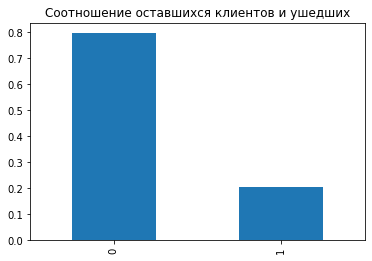

In [15]:
# Построим диаграмму подсчета классов
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', title='Соотношение оставшихся клиентов и ушедших') 

Большая разница, ушедших клиентов - 2037, оставшихся - 7963. 

In [16]:
 # Применим прямое кодирование ко всему датафрейму. 
data_ohe = pd.get_dummies(data, drop_first=True) # Сохраним таблицу в переменной data_ohe.
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [17]:
data.shape

(9091, 11)

In [18]:
# Разобъем данные после OHE 
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)
train, check = train_test_split(data_ohe, train_size=0.6, random_state=12345, stratify = data_ohe['Exited'])
valid, test = train_test_split(check, test_size=0.5, random_state=12345)
print(train.shape)
print(valid.shape)
print(test.shape)

(5454, 12)
(1818, 12)
(1819, 12)


In [19]:
# объявим переменные features и target для каждой выборки
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']

features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

In [20]:
pd.options.mode.chained_assignment = None # добавляем код, чтобы не появлялось предупреждение

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts']
scaler = StandardScaler() # создадим объект этой структуры данных
scaler.fit(features_train[numeric]) # настроим объект на обучающих данных 
features_train[numeric] = scaler.transform(features_train[numeric]) # проеобразуем обучающую выборку
features_valid[numeric] = scaler.transform(features_valid[numeric]) # преобразуем валидационную выборку 

display(features_train.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8837,-1.292898,-0.660843,0.686341,0.786636,-0.910943,0,0,86786.41,0,0,1
1090,-1.563714,0.778434,1.034232,0.833795,-0.910943,1,0,179227.12,0,1,0
7609,1.581914,0.106771,-0.357331,-1.222967,0.789359,1,1,81908.09,0,1,1
7279,0.842379,0.010820,-1.053112,0.807063,-0.910943,1,1,74850.93,0,1,0
2245,-0.397123,-1.236554,-0.357331,-1.222967,0.789359,1,1,179780.74,0,1,0


Мы разбили данные к измерению качества и обучению. 

## Построение моделей без учета баланса 

In [21]:
# Дерево решений 
# Найдем лучший гиперпораметр max_depth

for depth in range(1,16,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234).fit(features_train,target_train)
    prediction=model_tree.predict(features_valid)
    
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5215946843853821
max_depth: 3 F1: 0.5266666666666666
max_depth: 4 F1: 0.5223613595706619
max_depth: 5 F1: 0.581081081081081
max_depth: 6 F1: 0.598984771573604
max_depth: 7 F1: 0.6046511627906976
max_depth: 8 F1: 0.5845648604269293
max_depth: 9 F1: 0.580542264752791
max_depth: 10 F1: 0.5767441860465116
max_depth: 11 F1: 0.5647743813682679
max_depth: 12 F1: 0.5446685878962536
max_depth: 13 F1: 0.5306704707560628
max_depth: 14 F1: 0.5281980742778543
max_depth: 15 F1: 0.516914749661705


In [22]:
# сохраним модель Дерево решений с лучшим гиперпараметром
model_tree=DecisionTreeClassifier(max_depth=7,random_state=1234).fit(features_train,target_train)

In [23]:
# рассчитаем AUC-ROC модели Дерево решений 
probabilities_valid = model_tree.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]    
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-Tree_before =',auc_roc_tree)

метрика AUC-ROC-Tree_before = 0.8256484176484176


Лучший параметр max_depth: 7, при котором F1: 0.6046, а метрика AUC-ROC = 0.8256

In [24]:
# случайный лес
f1_list = []
max_depth_list = []
estim_list = []

for md in range(1, 17):
    for est in range(2, 50):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=md, n_estimators=est)
        
        model_rf.fit(features_train, target_train)
        
        predictions_rf = model_rf.predict(features_valid)
        
        f1_rf = round(f1_score(target_valid, predictions_rf), 4)
        
        f1_list.append(f1_rf)
        max_depth_list.append(md)
        estim_list.append(est)

In [25]:
# собираем все списки в один
result_list = [max_depth_list, estim_list, f1_list]

# создаем датафрейм
df_random_forest = pd.DataFrame({'max_depth':max_depth_list, 'n_estimators':estim_list, 'f1':f1_list})

# из которого теперь легко вычленить интересующую нас информацию
# ввиду строки с максимальным значением accuracy и соответствующих гиперпараметров
display(df_random_forest[df_random_forest['f1']==df_random_forest['f1'].max()])

,max_depth,n_estimators,f1
688,15,18,0.62


In [26]:
# сохраним модель случайный лес с лучшими гиперпараметром
model_rf = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=18).fit(features_train, target_train)

In [27]:
probabilities_valid = model_rf.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]    
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-rf_before =',auc_roc_tree)

метрика AUC-ROC-rf_before = 0.8471074151074152


Лучшее значение при max_depth=15, n_estimators=18, f1=0.62, а метрика AUC-ROC = 0.8471

In [28]:
# модель логистической регрессии
model_logistic=LogisticRegression().fit(features_train,target_train)
prediction=model_logistic.predict(features_valid)
print('F1:',f1_score(target_valid,prediction))

F1: 0.0


In [29]:
probabilities_valid = model_logistic.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]    
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-logistic_before =',auc_roc_tree)

метрика AUC-ROC-logistic_before = 0.49366042966042967


В модели логистической регрессии f1=0.0, а метрика AUC-ROC = 0.4936

Рассматривая данные с дисбалансом и обучив три модели, можно сделать вывод, что самая лучшая модель - дерево решений, при max_depth=15, n_estimators=18, f1=0.62, а метрика AUC-ROC = 0.8471 

## Исправим дисбаланс

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8790, 11)
(8790,)


In [31]:
%%time
# модель Дерево Решений 
for depth in range(1,16,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=12345).fit(features_upsampled,target_upsampled)
    prediction=model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.5191313340227508
max_depth: 2 F1: 0.5463709677419355
max_depth: 3 F1: 0.5463709677419355
max_depth: 4 F1: 0.5630676084762866
max_depth: 5 F1: 0.5626242544731611
max_depth: 6 F1: 0.5728643216080402
max_depth: 7 F1: 0.55859375
max_depth: 8 F1: 0.5810663764961914
max_depth: 9 F1: 0.5502183406113538
max_depth: 10 F1: 0.5382131324004304
max_depth: 11 F1: 0.5450450450450449
max_depth: 12 F1: 0.5294797687861271
max_depth: 13 F1: 0.5240893066980024
max_depth: 14 F1: 0.5317365269461077
max_depth: 15 F1: 0.5238678090575275
CPU times: user 380 ms, sys: 11.9 ms, total: 392 ms
Wall time: 403 ms


In [32]:
# сохраним модель дерево решений с лучшим гиперпараметром
model_tree = DecisionTreeClassifier(max_depth=8,random_state=12345).fit(features_upsampled,target_upsampled)

In [33]:
probabilities_valid_tree = model_tree.predict_proba(features_valid) 
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]    
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-tree_after =',auc_roc_tree)
fpr_tree,tpr_tree,thresholds=roc_curve(target_valid,probabilities_one_valid_tree)

метрика AUC-ROC-tree_after = 0.49366042966042967


При max_depth = 8, F1 = 0.5810, AUC-ROC = 0.49

In [34]:
%%time
# Случайный Лес
f1_list = []
max_depth_list = []
estim_list = []

for md in range(1, 17):
    for est in range(2, 50):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=md, n_estimators=est)
        
        model_rf.fit(features_upsampled, target_upsampled)
        
        predictions_rf = model_rf.predict(features_valid)
        
        f1_rf = round(f1_score(target_valid, predictions_rf), 4)
        
        f1_list.append(f1_rf)
        max_depth_list.append(md)
        estim_list.append(est)

CPU times: user 2min 19s, sys: 1.03 s, total: 2min 20s
Wall time: 2min 21s


In [35]:
# собираем все списки в один
result_list = [max_depth_list, estim_list, f1_list]

# создаем датафрейм
df_random_forest = pd.DataFrame({'max_depth':max_depth_list, 'n_estimators':estim_list, 'f1':f1_list})

# из которого теперь легко вычленить интересующую нас информацию
# ввиду строки с максимальным значением accuracy и соответствующих гиперпараметров
display(df_random_forest[df_random_forest['f1']==df_random_forest['f1'].max()])

,max_depth,n_estimators,f1
562,12,36,0.6365


In [36]:
# сохраним модель случайный лес с лучшими гиперпараметрами 
model_rf = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=36).fit(features_upsampled, target_upsampled)

In [37]:
probabilities_valid_rf = model_rf.predict_proba(features_valid) 
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]    
auc_roc_rf_after = roc_auc_score(target_valid, probabilities_one_valid_rf) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-rf_after =',auc_roc_rf_after)
fpr_rf,tpr_rf,thresholds=roc_curve(target_valid,probabilities_one_valid_rf)

метрика AUC-ROC-rf_after = 0.8595518595518595


При гиперпараметрах max_depth=12, n_estimators=36, f1=0,6018, AUC-ROC=0.8595

In [38]:
%%time
# Логистическая Регрессия 
model_logistic=LogisticRegression().fit(features_upsampled,target_upsampled)
prediction=model_logistic.predict(features_valid)
print('F1:',f1_score(target_valid,prediction))

F1: 0.34199726402188785
CPU times: user 59.5 ms, sys: 28 ms, total: 87.5 ms
Wall time: 93.7 ms


In [39]:
probabilities_valid_log = model_logistic.predict_proba(features_valid) 
probabilities_one_valid_log = probabilities_valid_log[:, 1]    
auc_roc_logistic_after = roc_auc_score(target_valid, probabilities_one_valid_log) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-logistic_after =', auc_roc_logistic_after)
fpr_log,tpr_log,thresholds=roc_curve(target_valid,probabilities_one_valid_log)

метрика AUC-ROC-logistic_after = 0.5063395703395703


<Figure size 432x288 with 0 Axes>

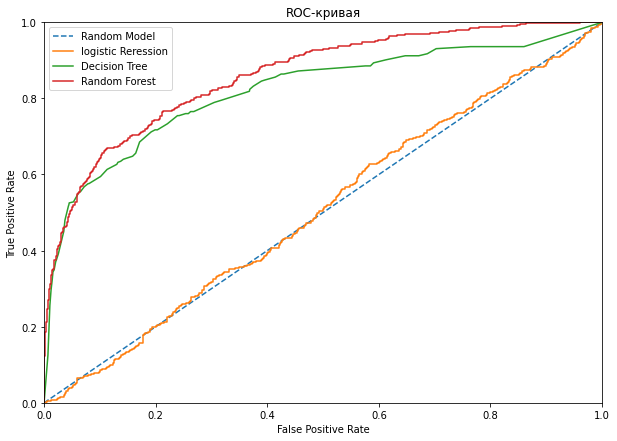

In [40]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_rf,tpr_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Random Model','logistic Reression','Decision Tree','Random Forest'),
           loc= 'upper left') 
plt.show()

In [41]:
rezult={'Дерево Решения':np.array([0.5810,0.4936]),'Случайный лес':np.array([0.6365,0.8595]),'Логистическая регрессия':np.array([0.3419,0.5063])}
rezult_df=pd.DataFrame(rezult,index=['F1-мера','AUC-ROC'])
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
F1-мера,0.5810,0.6365,0.3419
AUC-ROC,0.4936,0.8595,0.5063


In [42]:
# выполним downsampling
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2198, 11)
(2198,)


In [43]:
%%time
# модель Дерево Решений 
for depth in range(1,16,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=12345).fit(features_downsampled,target_downsampled)
    prediction=model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.5191313340227508
max_depth: 2 F1: 0.5463709677419355
max_depth: 3 F1: 0.5463709677419355
max_depth: 4 F1: 0.5668341708542713
max_depth: 5 F1: 0.5593719332679097
max_depth: 6 F1: 0.5685279187817259
max_depth: 7 F1: 0.5588822355289421
max_depth: 8 F1: 0.5702479338842975
max_depth: 9 F1: 0.5250255362614914
max_depth: 10 F1: 0.5401174168297456
max_depth: 11 F1: 0.5166340508806262
max_depth: 12 F1: 0.5196548418024928
max_depth: 13 F1: 0.5161904761904762
max_depth: 14 F1: 0.5046040515653776
max_depth: 15 F1: 0.5106382978723405
CPU times: user 169 ms, sys: 4.05 ms, total: 173 ms
Wall time: 188 ms


In [44]:
# сохраним модель дерево решений с лучшим гиперпараметром
model_tree = DecisionTreeClassifier(max_depth=8,random_state=12345).fit(features_downsampled,target_downsampled)

In [45]:
probabilities_valid_tree = model_tree.predict_proba(features_valid) 
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]    
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-tree_after =',auc_roc_tree)
fpr_tree,tpr_tree,thresholds=roc_curve(target_valid,probabilities_one_valid_tree)

метрика AUC-ROC-tree_after = 0.49366042966042967


In [46]:
%%time
# Случайный Лес
f1_list = []
max_depth_list = []
estim_list = []

for md in range(1, 17):
    for est in range(2, 50):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=md, n_estimators=est)
        
        model_rf.fit(features_downsampled, target_downsampled)
        
        predictions_rf = model_rf.predict(features_valid)
        
        f1_rf = round(f1_score(target_valid, predictions_rf), 4)
        
        f1_list.append(f1_rf)
        max_depth_list.append(md)
        estim_list.append(est)

CPU times: user 1min 2s, sys: 580 ms, total: 1min 3s
Wall time: 1min 3s


In [47]:
# собираем все списки в один
result_list = [max_depth_list, estim_list, f1_list]

# создаем датафрейм
df_random_forest = pd.DataFrame({'max_depth':max_depth_list, 'n_estimators':estim_list, 'f1':f1_list})

# из которого теперь легко вычленить интересующую нас информацию
# ввиду строки с максимальным значением accuracy и соответствующих гиперпараметров
display(df_random_forest[df_random_forest['f1']==df_random_forest['f1'].max()])

,max_depth,n_estimators,f1
415,9,33,0.6092


In [48]:
# сохраним модель случайный лес с лучшими гиперпараметрами 
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=33).fit(features_upsampled, target_upsampled)

In [49]:
probabilities_valid_rf = model_rf.predict_proba(features_valid) 
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]    
auc_roc_rf_after = roc_auc_score(target_valid, probabilities_one_valid_rf) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-rf_after =',auc_roc_rf_after)
fpr_rf,tpr_rf,thresholds=roc_curve(target_valid,probabilities_one_valid_rf)

метрика AUC-ROC-rf_after = 0.8624790944790945


In [50]:
%%time
# Логистическая Регрессия 
model_logistic=LogisticRegression().fit(features_downsampled,target_downsampled)
prediction=model_logistic.predict(features_valid)
print('F1:',f1_score(target_valid,prediction))

F1: 0.34199726402188785
CPU times: user 33.1 ms, sys: 28.1 ms, total: 61.2 ms
Wall time: 44.7 ms


In [51]:
probabilities_valid_log = model_logistic.predict_proba(features_valid) 
probabilities_one_valid_log = probabilities_valid_log[:, 1]    
auc_roc_logistic_after = roc_auc_score(target_valid, probabilities_one_valid_log) #применяем функцию roc_auc_score 
print('метрика AUC-ROC-logistic_after =', auc_roc_logistic_after)
fpr_log,tpr_log,thresholds=roc_curve(target_valid,probabilities_one_valid_log)

метрика AUC-ROC-logistic_after = 0.5063395703395703


<Figure size 432x288 with 0 Axes>

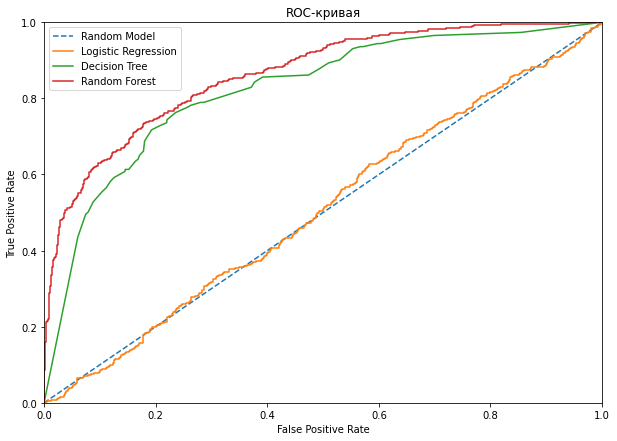

In [52]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_rf,tpr_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Random Model','Logistic Regression','Decision Tree','Random Forest'),
           loc= 'upper left') 
plt.show()

In [53]:
rezult={'Дерево Решения':np.array([0.5702,0.4936]),'Случайный лес':np.array([0.6092,0.8624]),'Логистическая регрессия':np.array([0.3419,0.5063])}
rezult_df=pd.DataFrame(rezult,index=['F1-мера','AUC-ROC'])
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
F1-мера,0.5702,0.6092,0.3419
AUC-ROC,0.4936,0.8624,0.5063


## Финальное тестирование 

In [54]:
features_test[numeric] = scaler.transform(features_test[numeric]) # преобразуем тестовую выборку 

In [55]:
prediction_test = model_rf.predict(features_test)

print('F1:',f1_score(target_test,prediction_test))

F1: 0.6055488540410133


F1-мера на тестовой выборке дала результат в 0,606. 

In [56]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1946,-0.459619,2.505566,1.730013,0.798907,2.489660,0,0,7861.68,1,0,1
1459,0.404908,-0.085132,-0.009440,-0.021190,-0.910943,1,1,8651.92,0,1,1
869,1.040283,-0.277036,1.034232,0.584939,-0.910943,0,1,9855.81,0,1,0
7634,-0.699187,0.106771,-0.705222,-1.222967,0.789359,1,0,47728.00,0,0,1
533,-0.407539,0.202723,-1.053112,0.605217,-0.910943,1,0,164061.60,1,0,0


## Общий вывод
В ходе исследования данные были изучены и обработаны. 
Были обучены три модели без учета дисбаланса классов, затем с учетом дисбаланса. Качество после исправления дисбаланса улучшилось. 
Но F1-мера на тестовой выборке всего-лишь 0.185. 